# Q-Learning for the Knapsack Problem

## 1. Problem Formulation

### 1.1 The Knapsack Problem

The knapsack problem is a classic optimization problem: given a set of items, each with a weight and a value, determine which items to include in a collection so that the total weight is less than or equal to a given capacity and the total value is maximized.

Formally, we have:
- A set of $n$ items, each with:
  - Weight $w_i$
  - Value $v_i$
- A knapsack with capacity $W$
- Goal: Maximize $\sum_{i=1}^{n} v_i x_i$ subject to $\sum_{i=1}^{n} w_i x_i \leq W$
  - Where $x_i \in \{0,1\}$ is a binary decision variable (include item $i$ or not)

### 1.2 Casting as a Reinforcement Learning Problem

To solve using Q-learning, we need to formulate the knapsack problem as a Markov Decision Process (MDP):

**State**: $(c, I)$ where:
- $c$ = Remaining capacity of the knapsack
- $I$ = Set of remaining items to consider

**Action**: For each item, we have two possible actions:
- Take the item (action = 1)
- Skip the item (action = 0)

**Reward**: 
- If action = 1 (take item $i$) and the item fits: $r = v_i$ (the item's value)
- Otherwise: $r = 0$

**Transition**: If in state $(c, I)$ with $I = \{i, i+1, ..., n\}$:
- If action = 1 and $w_i \leq c$:
  - Next state = $(c - w_i, \{i+1, ..., n\})$
- If action = 0 or $w_i > c$:
  - Next state = $(c, \{i+1, ..., n\})$

**Terminal State**: When there are no more items to consider: $I = \emptyset$

## 2. Q-Learning Algorithm: Understanding the Intuition

### 2.1 The Q-Learning Update Rule: Building Intuition

Q-learning helps us discover the best actions to take in different states. The core idea is simple:

> **Q-values tell us: "If I'm in state S and take action A, how much total reward can I expect to get from now until the end?"**

Let's break down how Q-learning works in an intuitive way:

#### What are Q-values?

A Q-value, written as Q(s,a), represents our estimate of the total future reward we expect to get if we:
1. Start in state s
2. Take action a
3. Follow the best possible actions afterward

#### How Q-learning updates our knowledge

When we try an action in a state and observe the results, we update our knowledge using this intuition:

**New estimate = Old estimate + (Learning rate) × [Observed outcome - Old estimate]**

This is like saying: "Let me adjust my expectations based on what actually happened."

#### The Q-Learning Formula Explained

The mathematical formula looks like this:

$$Q(s,a) \leftarrow Q(s,a) + \alpha \cdot [r + \gamma \cdot \max_{a'} Q(s',a') - Q(s,a)]$$

Breaking this down into understandable pieces:

1. **Q(s,a)**: Our current estimate of how good it is to take action a in state s

2. **r**: The immediate reward we just got

3. **γ · max Q(s',a')**: Our best estimate of future rewards from the next state
   - γ (gamma) is the discount factor (typically 0.9)
   - It's like saying: "Future rewards are slightly less valuable than immediate rewards"
   - max Q(s',a') finds the best expected reward from the next state

4. **[r + γ · max Q(s',a') - Q(s,a)]**: The "surprise" or error in our prediction
   - If this is positive, we got more than expected
   - If negative, we got less than expected

5. **α (alpha)**: The learning rate (typically 0.1)
   - Controls how much we adjust our estimate
   - Small α: Change estimates slowly (more stable, slower learning)
   - Large α: Change estimates quickly (less stable, faster learning)

#### A Simple Analogy

Think of Q-learning like learning to navigate a city to find the best restaurants:

- **States (s)**: Street intersections
- **Actions (a)**: Which direction to go
- **Rewards (r)**: How good each restaurant is
- **Q-values**: Your estimate of how good a meal you'll eventually get if you go in a particular direction from each intersection
- **Update rule**: Adjusting your expectations after trying different routes and restaurants

### 2.2 Exploration vs. Exploitation: The Learning Dilemma

Q-learning faces a fundamental challenge: 
- **Exploitation**: Use what we've learned so far to get the best rewards
- **Exploration**: Try new things to potentially discover better options

To balance these, we use an epsilon-greedy policy:
- With probability ε (epsilon): Choose a random action (explore)
- With probability (1-ε): Choose the action with the highest Q-value (exploit)

$$a = \begin{cases} 
\text{random action} & \text{with probability } \epsilon \\
\arg\max_{a} Q(s,a) & \text{with probability } 1 - \epsilon
\end{cases}$$

This is like saying: "Most of the time I'll go to the restaurant I think is best, but occasionally I'll try somewhere new just to see if there's something better."

##### Why Exploration Matters
Without exploration, we might get stuck always taking actions we initially thought were good, never discovering truly optimal solutions.

## 3. Step-by-Step Learning Process: Worked Example

Let's illustrate the Q-learning process with a concrete example:

**Example Problem**:
- Items: $\{0, 1, 2\}$ with weights $[2, 1, 3]$ and values $[12, 10, 20]$
- Knapsack capacity: 5

### 3.1 Initialization

1. Initialize Q-table with zeros for all state-action pairs
2. Set initial state: $(5, \{0, 1, 2\})$ (capacity = 5, all items available)

| State | Action | Q-value |
|-------|--------|---------|
| $(5, \{0, 1, 2\})$ | Take | 0.0 |
| $(5, \{0, 1, 2\})$ | Skip | 0.0 |
| ... | ... | ... |

### 3.2 First Iteration: Processing Item 0

**Current State**: $(5, \{0, 1, 2\})$

**Step 1: Choose Action**
- Using epsilon-greedy policy, we randomly choose: Action = Take (1)

**Step 2: Execute Action and Get New State and Reward**
- Take item 0: It weighs 2 units and has value 12
- New remaining capacity: $5 - 2 = 3$
- New remaining items: $\{1, 2\}$
- Reward = 12 (value of the item taken)
- New state: $(3, \{1, 2\})$

**Step 3: Update Q-value**

Let's walk through this update step-by-step:

1. **Current Q-value**: 
   - $Q((5, \{0, 1, 2\}), \text{Take}) = 0$

2. **Identify the next state's best action**:
   - Next state is $(3, \{1, 2\})$
   - If we've never visited this state, we initialize its Q-values to 0:
     - $Q((3, \{1, 2\}), \text{Take}) = 0$
     - $Q((3, \{1, 2\}), \text{Skip}) = 0$
   - Best action in the next state has value: $\max(0, 0) = 0$

3. **Calculate what we observed vs. what we expected**:
   - What we observed: immediate reward + discounted future rewards = $12 + 0.9 \times 0 = 12$
   - What we expected: our current Q-value = $0$
   - The difference (TD error): $12 - 0 = 12$

4. **Update our Q-value**:
   - How much to adjust? Learning rate × TD error = $0.1 \times 12 = 1.2$
   - New Q-value = Old Q-value + adjustment = $0 + 1.2 = 1.2$

So our updated Q-value is:
   - $Q((5, \{0, 1, 2\}), \text{Take}) = 1.2$

**Updated Q-table**:

| State | Action | Q-value |
|-------|--------|---------|
| $(5, \{0, 1, 2\})$ | Take | 1.2 |
| $(5, \{0, 1, 2\})$ | Skip | 0.0 |
| $(3, \{1, 2\})$ | Take | 0.0 |
| $(3, \{1, 2\})$ | Skip | 0.0 |

### 3.3 Second Iteration: Processing Item 1

**Current State**: $(3, \{1, 2\})$

**Step 1: Choose Action**
- Again using epsilon-greedy, choose: Action = Take (1)

**Step 2: Execute Action and Get New State and Reward**
- Take item 1: It weighs 1 unit and has value 10
- New remaining capacity: $3 - 1 = 2$
- New remaining items: $\{2\}$
- Reward = 10
- New state: $(2, \{2\})$

**Step 3: Update Q-value**

Again, let's break down this update:

1. **Current Q-value**: 
   - $Q((3, \{1, 2\}), \text{Take}) = 0$

2. **Identify the next state's best action**:
   - Next state is $(2, \{2\})$
   - Initialize if needed:
     - $Q((2, \{2\}), \text{Take}) = 0$
     - $Q((2, \{2\}), \text{Skip}) = 0$
   - Best action has value: $\max(0, 0) = 0$

3. **Calculate what we observed vs. what we expected**:
   - What we observed: immediate reward + discounted future rewards = $10 + 0.9 \times 0 = 10$
   - What we expected: our current Q-value = $0$
   - The difference (TD error): $10 - 0 = 10$

4. **Update our Q-value**:
   - How much to adjust? Learning rate × TD error = $0.1 \times 10 = 1.0$
   - New Q-value = Old Q-value + adjustment = $0 + 1.0 = 1.0$

So our updated Q-value is:
   - $Q((3, \{1, 2\}), \text{Take}) = 1.0$

**Updated Q-table**:

| State | Action | Q-value |
|-------|--------|---------|
| $(5, \{0, 1, 2\})$ | Take | 1.2 |
| $(5, \{0, 1, 2\})$ | Skip | 0.0 |
| $(3, \{1, 2\})$ | Take | 1.0 |
| $(3, \{1, 2\})$ | Skip | 0.0 |
| $(2, \{2\})$ | Take | 0.0 |
| $(2, \{2\})$ | Skip | 0.0 |

### 3.4 Third Iteration: Processing Item 2

**Current State**: $(2, \{2\})$

**Step 1: Choose Action**
- Using epsilon-greedy, choose: Action = Skip (0)
  - Note: We can't take item 2 as it weighs 3 units which exceeds our remaining capacity of 2.

**Step 2: Execute Action and Get New State and Reward**
- Skip item 2
- New remaining capacity: remains 2
- New remaining items: $\{\}$ (empty - terminal state)
- Reward = 0
- New state: $(2, \{\})$ (terminal)

**Step 3: Update Q-value**

1. **Current Q-value**: 
   - $Q((2, \{2\}), \text{Skip}) = 0$

2. **Terminal state has no future value**:
   - Terminal states have no actions to take, so future value is 0

3. **Calculate what we observed vs. what we expected**:
   - What we observed: immediate reward + discounted future rewards = $0 + 0 = 0$
   - What we expected: our current Q-value = $0$
   - The difference (TD error): $0 - 0 = 0$

4. **Update our Q-value**:
   - How much to adjust? Learning rate × TD error = $0.1 \times 0 = 0$
   - New Q-value = Old Q-value + adjustment = $0 + 0 = 0$

Since the TD error is 0, our Q-value doesn't change:
   - $Q((2, \{2\}), \text{Skip}) = 0$

**Updated Q-table**:

| State | Action | Q-value |
|-------|--------|---------|
| $(5, \{0, 1, 2\})$ | Take | 1.2 |
| $(5, \{0, 1, 2\})$ | Skip | 0.0 |
| $(3, \{1, 2\})$ | Take | 1.0 |
| $(3, \{1, 2\})$ | Skip | 0.0 |
| $(2, \{2\})$ | Take | 0.0 |
| $(2, \{2\})$ | Skip | 0.0 |

### 3.5 End of Episode

This completes one episode. The total reward was $12 + 10 + 0 = 22$.

In this episode, we took items 0 and 1, using a total weight of $2 + 1 = 3$ and getting a total value of $12 + 10 = 22$.

## 4. Multiple Episodes and Value Propagation: The Learning Magic

The true power of Q-learning emerges across multiple episodes as value information propagates backward:

### 4.1 Backward Value Propagation: Learning from the Future

Think of Q-learning like planning a road trip in reverse: you first learn what destinations are worth visiting, then gradually figure out which routes get you there.

**Visualization of value propagation:**

```
Episode 1:  (5,{0,1,2}) → (3,{1,2}) → (2,{2}) → Terminal
             Take:1.2      Take:1.0     Skip:0
             ↑             ↑            ↑
             Reward:12     Reward:10    Reward:0
```

After many episodes, Q-values start to reflect not just immediate rewards but all future rewards:

**Early Episodes**: 
- Q-values only reflect immediate rewards
- $Q((5, \{0, 1, 2\}), \text{Take}) = 1.2$ (just a fraction of item 0's value)

**After Several Episodes**:
- Values propagate backward
- $Q((5, \{0, 1, 2\}), \text{Take}) \approx 12 + 0.9 \times \text{(best future value)}$
- $Q((3, \{1, 2\}), \text{Take}) \approx 10 + 0.9 \times \text{(best future value)}$

This backward propagation of values reveals which initial decisions lead to the best overall outcomes. It's like first discovering a treasure, then learning which paths lead to it.

### 4.2 Convergence: Finding the Optimal Solution

After many episodes:

1. **Q-values stabilize**: They approach the true expected rewards of each action.

2. **For our example, the optimal solution emerges**:
   - Skip item 0
   - Take item 1 (weight 1, value 10)
   - Take item 2 (weight 3, value 20)
   - Total weight: 4, Total value: 30

3. The final Q-table might look like:

| State | Take | Skip |
|-------|------|------|
| $(5, \{0, 1, 2\})$ | 22.0 | 30.0 |
| $(3, \{1, 2\})$ | 22.0 | 20.0 |
| $(5, \{1, 2\})$ | 30.0 | 20.0 |
| $(2, \{2\})$ | 0.0 | 0.0 |
| $(4, \{2\})$ | 20.0 | 0.0 |
| ... | ... | ... |

Looking at this table, we can now interpret what it's telling us:
- At state $(5, \{0, 1, 2\})$, skipping item 0 leads to better overall value (30.0) than taking it (22.0)
- At state $(5, \{1, 2\})$, taking item 1 leads to better overall value (30.0) than skipping it (20.0)
- At state $(4, \{2\})$, taking item 2 leads to better overall value (20.0) than skipping it (0.0)

### 4.3 Extracting the Optimal Policy: Using What We've Learned

Once Q-learning has converged, finding the best solution is simple:
1. Start at the initial state
2. At each state, choose the action with the highest Q-value
3. Follow this path until you reach a terminal state

Let's extract the optimal policy from our example:

1. Start at state $(5, \{0, 1, 2\})$:
   - $Q(\text{Take}) = 22.0$, $Q(\text{Skip}) = 30.0$
   - Choose skip (move to state $(5, \{1, 2\})$)

2. At state $(5, \{1, 2\})$:
   - $Q(\text{Take}) = 30.0$, $Q(\text{Skip}) = 20.0$
   - Choose take (move to state $(4, \{2\})$)

3. At state $(4, \{2\})$:
   - $Q(\text{Take}) = 20.0$, $Q(\text{Skip}) = 0.0$
   - Choose take

4. Terminal state reached, total value = 30

This is precisely the optimal solution to our knapsack problem!

## 5. Learning Process Evolution: The Journey to Optimality

### 5.1 Early Episodes: Exploration Dominated

In early episodes:
- Q-values start at zero (complete uncertainty)
- Actions are mostly random due to high exploration rate (typically ε = 0.9)
- The agent makes many mistakes but collects valuable experiences
- Q-values begin to capture immediate rewards

**Visual representation:**
```
Early Episodes: Mostly random walks
  → Many different paths tried
  → Q-values only reflect immediate rewards
  → Performance is poor and inconsistent
```

### 5.2 Middle Episodes: Balancing Exploration and Exploitation

The middle phase of Q-learning is where the real "learning magic" happens. Let's examine this crucial phase in detail:

#### 5.2.1 What's Happening in the Q-Table

During intermediate episodes, our Q-table contains a mix of:
- **Well-established values**: States we've visited frequently have relatively stable Q-values
- **Partially-learned values**: States we've visited occasionally have rough estimates
- **Unknown values**: States we've rarely or never visited still have default (zero) values

**Example Q-table after 50 episodes might look like:**

| State | Take | Skip |
|-------|------|------|
| $(5, \{0,1,2\})$ | 20.5 | 24.3 |
| $(3, \{1,2\})$ | 18.7 | 12.1 |
| $(5, \{1,2\})$ | 26.8 | 15.2 |
| ... | ... | ... |

#### 5.2.2 The Value Propagation Process in Action

Let's trace through what happens in a specific middle episode (e.g., Episode #51):

1. **Initial state**: $(5, \{0,1,2\})$
   - Current Q-values: Take = 20.5, Skip = 24.3
   - ε = 0.5 (50% chance of random action)
   - Let's say our random value is 0.7, so we'll choose the best action: Skip
   - This takes us to state $(5, \{1,2\})$

2. **At state**: $(5, \{1,2\})$
   - Current Q-values: Take = 26.8, Skip = 15.2
   - We choose Take (it's the better action)
   - Get reward = 10 (value of item 1)
   - Move to state $(4, \{2\})$

3. **At state**: $(4, \{2\})$
   - Current Q-values: Take = 17.5, Skip = 0.0
   - We choose Take (it's better)
   - Get reward = 20 (value of item 2)
   - Move to terminal state

4. **Now the crucial part - updating Q-values backward:**
   
   a. First, update $Q((4, \{2\}), \text{Take})$:
      - TD target = immediate reward + future value = 20 + 0 = 20
      - TD error = 20 - 17.5 = 2.5
      - New Q-value = 17.5 + 0.1 × 2.5 = 17.75
   
   b. Next, update $Q((5, \{1,2\}), \text{Take})$:
      - TD target = immediate reward + future value = 10 + 0.9 × 17.75 = 25.975
      - TD error = 25.975 - 26.8 = -0.825 (we overestimated slightly)
      - New Q-value = 26.8 + 0.1 × (-0.825) = 26.7175
   
   c. Finally, update $Q((5, \{0,1,2\}), \text{Skip})$:
      - TD target = immediate reward + future value = 0 + 0.9 × 26.7175 = 24.04575
      - TD error = 24.04575 - 24.3 = -0.25425 (slight overestimation)
      - New Q-value = 24.3 + 0.1 × (-0.25425) = 24.27457

Notice how the updates ripple backward, with each state's value being influenced by the next state's updated value. This is the **temporal difference learning** process in action!

| State           | Action | Old Q | New Q   | Reward | Future Q     |
| --------------- | ------ | ----- | ------- | ------ | ------------ |
| \$(4,{2})\$     | Take   | 17.5  | 17.75   | 20     | 0 (terminal) |
| \$(5,{1,2})\$   | Take   | 26.8  | 26.695  | 10     | 17.75        |
| \$(5,{0,1,2})\$ | Skip   | 24.3  | 24.2725 | 0      | 26.695       |


#### 5.2.3 The Balance Between Exploration and Exploitation

The choice of exploration rate (ε) is critical during middle episodes:

- **Too much exploration** (high ε): We waste time trying already-known suboptimal paths
- **Too little exploration** (low ε): We might get stuck in a local optimum, never discovering the truly best path

**Visual representation of exploration-exploitation balance:**

```
                 ↗ Better solutions
Exploration      ↑ (exploring new paths)
    ↑            |
    |         ⚪ ← Current best solution
    |            |
    ↓            ↓ Worse solutions
Exploitation  (refining known paths)
```

Most effective learning occurs with an **annealing schedule** that gradually reduces ε:
- Early episodes: ε ≈ 0.9 (90% random actions)
- Middle episodes: ε ≈ 0.5 (50% random actions)
- Late episodes: ε ≈ 0.1 (10% random actions)

#### 5.2.4 Emerging Patterns During Middle Episodes

The mid-learning phase displays several interesting patterns:

1. **Insight moments**: Occasionally, exploration leads to discovering significantly better paths, causing rapid changes in Q-values

2. **Path crystallization**: The highest-value paths become increasingly clear, appearing as "highways" of high Q-values in the table

3. **Diminishing updates**: The size of Q-value updates generally decreases as values converge toward their true values

4. **Performance variability**: The overall performance graph looks "sawtooth" shaped, with exploration causing occasional dips but the trend moving upward:

```
Reward
  ^
  |        _/‾\_      _/‾\_/‾‾‾‾
  |    _/‾/    \_/‾‾‾/
  | _/‾
  |/
  +-------------------------> Episodes
    Early    Middle     Late
```

#### 5.2.5 A Concrete Multi-Episode Example

Let's examine how Q-values for our initial state $(5, \{0,1,2\})$ might evolve across episodes:

| Episode | Q(Take) | Q(Skip) | Action Chosen | Episode Reward |
|---------|---------|---------|---------------|---------------|
| 5       | 4.8     | 3.2     | Take (random) | 22            |
| 10      | 8.2     | 7.5     | Take (best)   | 22            |
| 20      | 12.9    | 14.1    | Skip (best)   | 30            |
| 30      | 15.7    | 18.4    | Skip (best)   | 30            |
| 40      | 18.2    | 21.5    | Skip (best)   | 30            |
| 50      | 20.5    | 24.3    | Take (random) | 22            |
| 60      | 21.0    | 26.8    | Skip (best)   | 30            |

Notice how:
1. Initially, both options have low values since future rewards aren't recognized
2. The "Take" action (selecting item 0) appears better in early episodes
3. As value propagation occurs, "Skip" emerges as the superior choice
4. Occasional exploration still happens (episode 50), which temporarily lowers performance
5. The gap between Q-values gradually widens, showing increasing confidence in the optimal policy

This entire middle phase represents the heart of Q-learning: the system is actively balancing the need to explore new possibilities against the desire to exploit what it already knows works well.


### 5.3 Late Episodes: Exploitation Dominated

In later episodes:
- Q-values approach their optimal values
- Exploration rate is very low (e.g., ε = 0.1)
- The agent mostly exploits its accumulated knowledge
- Performance stabilizes near the optimal solution

**Visual representation:**
```
Late Episodes: Consistent optimal paths
  → Same optimal path taken consistently
  → Q-values closely approximate true values
  → Performance is stable and near-optimal
```

## 6. Practical Considerations: Making Q-Learning Work

### 6.1 State Representation Challenges

For the knapsack problem, our state representation $(c, I)$ grows exponentially with the number of items. For larger problems, we might need:

- **State Approximation**: Group similar states together
- **Function Approximation**: Use neural networks instead of tables (Deep Q-Learning)
- **Feature-based Representation**: Transform states into feature vectors

### 6.2 Hyperparameter Tuning

Q-learning performance depends on several hyperparameters:

- **Learning Rate (α)**: 
  - Too high: Unstable learning
  - Too low: Very slow learning
  - Typical range: 0.01 to 0.1

- **Discount Factor (γ)**:
  - Higher values (0.9-0.99): More emphasis on future rewards
  - Lower values (0.5-0.8): More emphasis on immediate rewards

- **Exploration Rate (ε)**:
  - Start high (0.9) and decay over time
  - Common decay: ε = ε₀/(1 + kt) where k is a decay rate

### 6.3 Dealing with Large State Spaces

For practical knapsack problems with many items:

1. **Deep Q-Networks (DQN)**: Replace Q-tables with neural networks
2. **Approximate Dynamic Programming**: Combine RL with traditional optimization
3. **Heuristics**: Use Q-learning to guide heuristic search

## 7. Conclusion: The Power of Q-Learning

Q-learning offers several advantages for solving the knapsack problem:

1. **Model-Free**: No need to know transition probabilities
2. **Off-Policy**: Can learn from random or exploratory actions
3. **Convergence**: Guaranteed to find optimal policy given enough exploration
4. **Adaptability**: Can handle variations like changing item values or constraints

While traditional dynamic programming approaches are more efficient for standard knapsack problems, Q-learning becomes valuable when:
- The problem structure changes dynamically
- There are additional constraints or complexities
- We want to learn policies that generalize across different problem instances

The core insight of Q-learning—learning which decisions lead to the best long-term outcomes—makes it a powerful framework not just for knapsack problems, but for a wide range of sequential decision-making challenges.

In [5]:
import numpy as np
import random
import time
from tabulate import tabulate  # For pretty printing tables
from colorama import Fore, Back, Style, init  # For colored terminal output

# Initialize colorama
init(autoreset=True)

class KnapsackQLearning:
    def __init__(self, weights, values, capacity, 
                alpha=0.1, gamma=0.9, epsilon=0.1, max_episodes=200):
        """
        Initialize the Q-learning agent for the knapsack problem.
        
        Parameters:
        -----------
        weights : list
            Weights of the items
        values : list
            Values of the items
        capacity : int
            Capacity of the knapsack
        alpha : float
            Learning rate
        gamma : float
            Discount factor
        epsilon : float
            Exploration rate
        max_episodes : int
            Maximum number of episodes for training
        """
        self.weights = weights
        self.values = values
        self.capacity = capacity
        self.n_items = len(weights)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_episodes = max_episodes
        
        # Initialize Q-table as a dictionary (for sparse representation)
        self.q_table = {}
        
        # Initialize episode history
        self.episode_history = []
        
        # Print problem setup
        self._print_problem_setup()
    
    def _print_problem_setup(self):
        """Print the problem setup with nice formatting."""
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}Q-LEARNING FOR KNAPSACK PROBLEM")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print(f"\n{Fore.YELLOW}Problem Setup:")
        print(f"  - Items: {self.n_items}")
        print(f"  - Weights: {self.weights}")
        print(f"  - Values: {self.values}")
        print(f"  - Knapsack Capacity: {self.capacity}")
        
        print(f"\n{Fore.YELLOW}Learning Parameters:")
        print(f"  - Learning Rate (α): {self.alpha}")
        print(f"  - Discount Factor (γ): {self.gamma}")
        print(f"  - Exploration Rate (ε): {self.epsilon}")
        print(f"  - Maximum Episodes: {self.max_episodes}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "-"*80)
    
    def _get_state_key(self, state):
        """Convert state to a hashable tuple for Q-table lookup."""
        return (state[0], tuple(state[1]))
    
    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy policy.
        
        Parameters:
        -----------
        state : tuple
            Current state (remaining_capacity, remaining_items)
            
        Returns:
        --------
        int
            Action (0: skip, 1: take)
        """
        state_key = self._get_state_key(state)
        remaining_capacity, remaining_items = state
        
        # If no items left or first item doesn't fit, must skip
        if not remaining_items or self.weights[remaining_items[0]] > remaining_capacity:
            return 0
        
        # Initialize Q-values for this state if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {0: 0.0, 1: 0.0}  # Skip and Take
        
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            # Explore: random action
            return random.randint(0, 1)
        else:
            # Exploit: choose best action
            return max(self.q_table[state_key], key=self.q_table[state_key].get)
    
    def _print_state_info(self, state, action, reward, next_state):
        """Print detailed information about the current state and action."""
        remaining_capacity, remaining_items = state
        next_capacity, next_items = next_state
        
        action_str = "TAKE" if action == 1 else "SKIP"
        item_idx = remaining_items[0] if remaining_items else None
        
        # Current state
        print(f"\n{Fore.GREEN}Current State:")
        print(f"  - Remaining Capacity: {remaining_capacity}")
        print(f"  - Remaining Items: {remaining_items}")
        
        # Action and item
        if item_idx is not None:
            print(f"\n{Fore.BLUE}Action: {action_str} Item {item_idx}")
            print(f"  - Item Weight: {self.weights[item_idx]}")
            print(f"  - Item Value: {self.values[item_idx]}")
        else:
            print(f"\n{Fore.BLUE}Action: {action_str} (No items left)")
        
        # Reward
        print(f"\n{Fore.MAGENTA}Reward: {reward}")
        
        # Next state
        print(f"\n{Fore.GREEN}Next State:")
        print(f"  - Remaining Capacity: {next_capacity}")
        print(f"  - Remaining Items: {next_items}")
    
    def _print_q_update(self, state, action, old_q, reward, next_state, next_max_q, new_q):
        """Print the detailed Q-value update calculation."""
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        print(f"\n{Fore.YELLOW}Q-Value Update Calculation:")
        print(f"  - Current Q(s,a): Q{state_key, action} = {old_q:.4f}")
        
        if len(next_state[1]) > 0:  # If next state has items
            print(f"  - Next State Max Q-Value: max_a Q{next_state_key, 'a'} = {next_max_q:.4f}")
            print(f"  - TD Target: r + γ * max_a Q(s',a') = {reward} + {self.gamma} * {next_max_q:.4f} = {reward + self.gamma * next_max_q:.4f}")
        else:
            print(f"  - TD Target: r (terminal state) = {reward}")
        
        td_error = reward + self.gamma * next_max_q - old_q
        print(f"  - TD Error: r + γ * max_a Q(s',a') - Q(s,a) = {td_error:.4f}")
        
        print(f"  - Q-Update: Q(s,a) ← Q(s,a) + α * TD Error")
        print(f"    = {old_q:.4f} + {self.alpha} * {td_error:.4f}")
        print(f"    = {old_q:.4f} + {self.alpha * td_error:.4f}")
        print(f"    = {new_q:.4f}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}Updated Q-Value: Q{state_key, action} = {new_q:.4f}")
    
    def _print_q_table(self, highlight_state=None, highlight_action=None):
        """Print the current Q-table in a readable format."""
        if not self.q_table:
            print(f"\n{Fore.YELLOW}Q-Table is empty.")
            return
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}Current Q-Table:")
        
        # Prepare table data
        headers = ["State (Capacity, Items)", "Q(s,Skip)", "Q(s,Take)"]
        table_data = []
        
        # Sort states for consistent display
        sorted_states = sorted(self.q_table.keys())
        
        for state_key in sorted_states:
            skip_value = self.q_table[state_key].get(0, "N/A")
            take_value = self.q_table[state_key].get(1, "N/A")
            
            if skip_value != "N/A":
                skip_value = f"{skip_value:.4f}"
            if take_value != "N/A":
                take_value = f"{take_value:.4f}"
            
            # Highlight the updated state-action pair
            if highlight_state and highlight_state == state_key:
                if highlight_action == 0:
                    skip_value = f"{Fore.GREEN}{Style.BRIGHT}{skip_value}{Style.RESET_ALL}"
                elif highlight_action == 1:
                    take_value = f"{Fore.GREEN}{Style.BRIGHT}{take_value}{Style.RESET_ALL}"
            
            table_data.append([str(state_key), skip_value, take_value])
        
        # Print table
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    def update_q_value(self, state, action, reward, next_state, verbose=True):
        """
        Update the Q-value for the given state-action pair.
        
        Parameters:
        -----------
        state : tuple
            Current state (remaining_capacity, remaining_items)
        action : int
            Action taken (0: skip, 1: take)
        reward : float
            Reward received
        next_state : tuple
            Next state
        verbose : bool
            Whether to print detailed update information
        """
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        # Initialize Q-values if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {0: 0.0, 1: 0.0}
        if next_state_key not in self.q_table and len(next_state[1]) > 0:
            self.q_table[next_state_key] = {0: 0.0, 1: 0.0}
        
        # Get current Q-value
        old_q = self.q_table[state_key].get(action, 0.0)
        
        # Calculate next state's maximum Q-value
        if len(next_state[1]) > 0:  # If next state has items
            next_max_q = max(self.q_table[next_state_key].values())
        else:
            next_max_q = 0.0  # Terminal state
        
        # Q-learning update rule
        new_q = old_q + self.alpha * (reward + self.gamma * next_max_q - old_q)
        self.q_table[state_key][action] = new_q
        
        # Print detailed information if verbose
        if verbose:
            self._print_state_info(state, action, reward, next_state)
            self._print_q_update(state, action, old_q, reward, next_state, next_max_q, new_q)
            self._print_q_table(highlight_state=state_key, highlight_action=action)
        
        return new_q
    
    def run_episode(self, episode_num, verbose=True):
        """
        Run a single episode of Q-learning.
        
        Parameters:
        -----------
        episode_num : int
            Current episode number
        verbose : bool
            Whether to print detailed episode information
            
        Returns:
        --------
        total_reward : float
            Total reward collected in this episode
        """
        if verbose:
            print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
            print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE {episode_num}")
            print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        # Initialize state
        state = (self.capacity, tuple(range(self.n_items)))
        total_reward = 0
        selected_items = []
        
        while state[1]:  # While items remain
            # Choose action
            action = self.choose_action(state)
            
            # Get next item to consider
            item_idx = state[1][0]
            remaining_items = state[1][1:]
            
            # Take action and observe next state and reward
            if action == 1:  # Take item
                if self.weights[item_idx] <= state[0]:  # If can take
                    reward = self.values[item_idx]
                    next_state = (state[0] - self.weights[item_idx], remaining_items)
                    selected_items.append(item_idx)
                else:  # Cannot take, forced to skip
                    reward = 0
                    next_state = (state[0], remaining_items)
            else:  # Skip item
                reward = 0
                next_state = (state[0], remaining_items)
            
            # Update Q-value
            if verbose:
                print(f"\n{Fore.YELLOW}Step with Item {item_idx}:")
            
            self.update_q_value(state, action, reward, next_state, verbose=verbose)
            
            # Update total reward and state
            total_reward += reward
            state = next_state
        
        if verbose:
            print(f"\n{Fore.GREEN}{Style.BRIGHT}Episode {episode_num} Complete")
            print(f"{Fore.GREEN}Total Reward: {total_reward}")
            print(f"{Fore.GREEN}Selected Items: {selected_items}")
        
        # Record episode history
        self.episode_history.append((episode_num, total_reward, selected_items))
        
        return total_reward
    
    def train(self, verbose_episodes=None):
        """
        Train the Q-learning agent over multiple episodes.
        
        Parameters:
        -----------
        verbose_episodes : list
            List of episode numbers to print detailed information for
            
        Returns:
        --------
        rewards : list
            List of rewards for each episode
        """
        if verbose_episodes is None:
            verbose_episodes = [1, 10, 50, 100]
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}STARTING TRAINING FOR {self.max_episodes} EPISODES")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        rewards = []
        
        for episode in range(1, self.max_episodes + 1):
            # Determine verbosity for this episode
            verbose = episode in verbose_episodes
            
            # Run episode
            reward = self.run_episode(episode, verbose=verbose)
            rewards.append(reward)
            
            # Print progress
            if episode % 10 == 0 and episode not in verbose_episodes:
                print(f"Episode {episode}/{self.max_episodes}, Reward: {reward}")
            
            # Decay exploration rate
            self.epsilon = max(0.01, self.epsilon * 0.99)
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}TRAINING COMPLETE")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        return rewards
    
    def get_optimal_policy(self):
        """
        Extract optimal policy from learned Q-values.
        
        Returns:
        --------
        policy : dict
            Mapping from states to actions
        value : float
            Expected total value from optimal policy
        selected_items : list
            List of items selected by optimal policy
        """
        policy = {}
        state = (self.capacity, tuple(range(self.n_items)))
        total_value = 0
        selected_items = []
        
        while state[1]:
            state_key = self._get_state_key(state)
            item_idx = state[1][0]
            remaining_items = state[1][1:]
            
            # Get action from Q-table
            if state_key in self.q_table:
                # If we can't take the item, we have to skip
                if self.weights[item_idx] > state[0]:
                    action = 0
                else:
                    action = max(self.q_table[state_key], key=self.q_table[state_key].get)
            else:
                # Default to skip if state not in Q-table
                action = 0
            
            policy[state_key] = action
            
            if action == 1 and self.weights[item_idx] <= state[0]:
                total_value += self.values[item_idx]
                selected_items.append(item_idx)
                state = (state[0] - self.weights[item_idx], remaining_items)
            else:
                state = (state[0], remaining_items)
        
        return policy, total_value, selected_items
    
    def print_optimal_policy(self):
        """Print the optimal policy and solution."""
        policy, value, items = self.get_optimal_policy()
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}OPTIMAL SOLUTION FOUND")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print(f"\n{Fore.GREEN}Optimal Value: {value}")
        print(f"{Fore.GREEN}Selected Items: {items}")
        
        # Calculate weight
        total_weight = sum(self.weights[i] for i in items)
        print(f"{Fore.GREEN}Total Weight: {total_weight}/{self.capacity}")
        
        print(f"\n{Fore.YELLOW}Item Details:")
        table_data = []
        for i in range(self.n_items):
            status = "Selected" if i in items else "Not Selected"
            status_color = Fore.GREEN if i in items else Fore.RED
            table_data.append([i, self.weights[i], self.values[i], f"{status_color}{status}{Style.RESET_ALL}"])
        
        headers = ["Item", "Weight", "Value", "Status"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        print(f"\n{Fore.YELLOW}Optimal Policy:")
        table_data = []
        for state, action in policy.items():
            action_str = "Take" if action == 1 else "Skip"
            table_data.append([str(state), action_str])
        
        headers = ["State", "Action"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    def visualize_training_progress(self):
        """Visualize the training progress (text-based)."""
        episodes = [ep for ep, _, _ in self.episode_history]
        rewards = [r for _, r, _ in self.episode_history]
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}TRAINING PROGRESS")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        # Calculate best episode and reward
        best_ep_idx = np.argmax(rewards)
        best_episode = episodes[best_ep_idx]
        best_reward = rewards[best_ep_idx]
        best_items = self.episode_history[best_ep_idx][2]
        
        print(f"\n{Fore.GREEN}Best Episode: {best_episode}")
        print(f"{Fore.GREEN}Best Reward: {best_reward}")
        print(f"{Fore.GREEN}Best Items: {best_items}")
        
        # Print reward progress
        print(f"\n{Fore.YELLOW}Reward Progress:")
        
        # Generate a simple text-based progress chart
        max_reward = max(rewards)
        chart_width = 50
        
        for i, (ep, reward) in enumerate(zip(episodes, rewards)):
            if i % 10 == 0 or i == len(episodes) - 1:
                bar_length = int(reward / max_reward * chart_width)
                bar = "#" * bar_length
                print(f"Episode {ep:3d}: {reward:3.0f} |{bar}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)


def main():
    """Main function to run the Q-learning algorithm for the knapsack problem."""
    # Define problem
    weights = [2, 1, 3, 2, 4]
    values = [12, 10, 20, 15, 25]
    capacity = 7
    
    # Create agent
    agent = KnapsackQLearning(
        weights=weights,
        values=values,
        capacity=capacity,
        alpha=0.1,  # Learning rate
        gamma=0.9,  # Discount factor
        epsilon=0.1,  # Exploration rate
        max_episodes=100  # Maximum episodes
    )
    
    # Train the agent with verbose episodes
    verbose_episodes = [1, 10, 25, 50]
    rewards = agent.train(verbose_episodes=verbose_episodes)
    
    # Print the optimal policy
    agent.print_optimal_policy()
    
    # Visualize training progress
    agent.visualize_training_progress()


if __name__ == "__main__":
    main()


Q-LEARNING FOR KNAPSACK PROBLEM

Problem Setup:
  - Items: 5
  - Weights: [2, 1, 3, 2, 4]
  - Values: [12, 10, 20, 15, 25]
  - Knapsack Capacity: 7

Learning Parameters:
  - Learning Rate (α): 0.1
  - Discount Factor (γ): 0.9
  - Exploration Rate (ε): 0.1
  - Maximum Episodes: 100

--------------------------------------------------------------------------------

STARTING TRAINING FOR 100 EPISODES

EPISODE 1

Step with Item 0:

Current State:
  - Remaining Capacity: 7
  - Remaining Items: (0, 1, 2, 3, 4)

Action: SKIP Item 0
  - Item Weight: 2
  - Item Value: 12

Reward: 0

Next State:
  - Remaining Capacity: 7
  - Remaining Items: (1, 2, 3, 4)

Q-Value Update Calculation:
  - Current Q(s,a): Q((7, (0, 1, 2, 3, 4)), 0) = 0.0000
  - Next State Max Q-Value: max_a Q((7, (1, 2, 3, 4)), 'a') = 0.0000
  - TD Target: r + γ * max_a Q(s',a') = 0 + 0.9 * 0.0000 = 0.0000
  - TD Error: r + γ * max_a Q(s',a') - Q(s,a) = 0.0000
  - Q-Update: Q(s,a) ← Q(s,a) + α * TD Error
    = 0.0000 + 0.1 * 0.0000


Q-LEARNING FOR KNAPSACK PROBLEM

Problem Setup:
  - Items: 5
  - Weights: [2, 1, 3, 2, 4]
  - Values: [12, 10, 20, 15, 25]
  - Knapsack Capacity: 7

Learning Parameters:
  - Learning Rate (α): 0.1
  - Discount Factor (γ): 0.9
  - Exploration Rate (ε): 0.1
  - Maximum Episodes: 100

--------------------------------------------------------------------------------

STARTING TRAINING FOR 100 EPISODES

EPISODE 1

Step with Item 0:

Current State:
  - Remaining Capacity: 7
  - Remaining Items: (0, 1, 2, 3, 4)

Action: TAKE Item 0
  - Item Weight: 2
  - Item Value: 12

Reward: 12

Next State:
  - Remaining Capacity: 5
  - Remaining Items: (1, 2, 3, 4)

Q-Value Update Calculation:
  - Current Q(s,a): Q((7, (0, 1, 2, 3, 4)), 1) = 0.0000
  - Next State Max Q-Value: max_a Q((5, (1, 2, 3, 4)), 'a') = 0.0000
  - TD Target: r + γ * max_a Q(s',a') = 12 + 0.9 * 0.0000 = 12.0000
  - TD Error: r + γ * max_a Q(s',a') - Q(s,a) = 12.0000
  - Q-Update: Q(s,a) ← Q(s,a) + α * TD Error
    = 0.0000 + 0.1 * 12

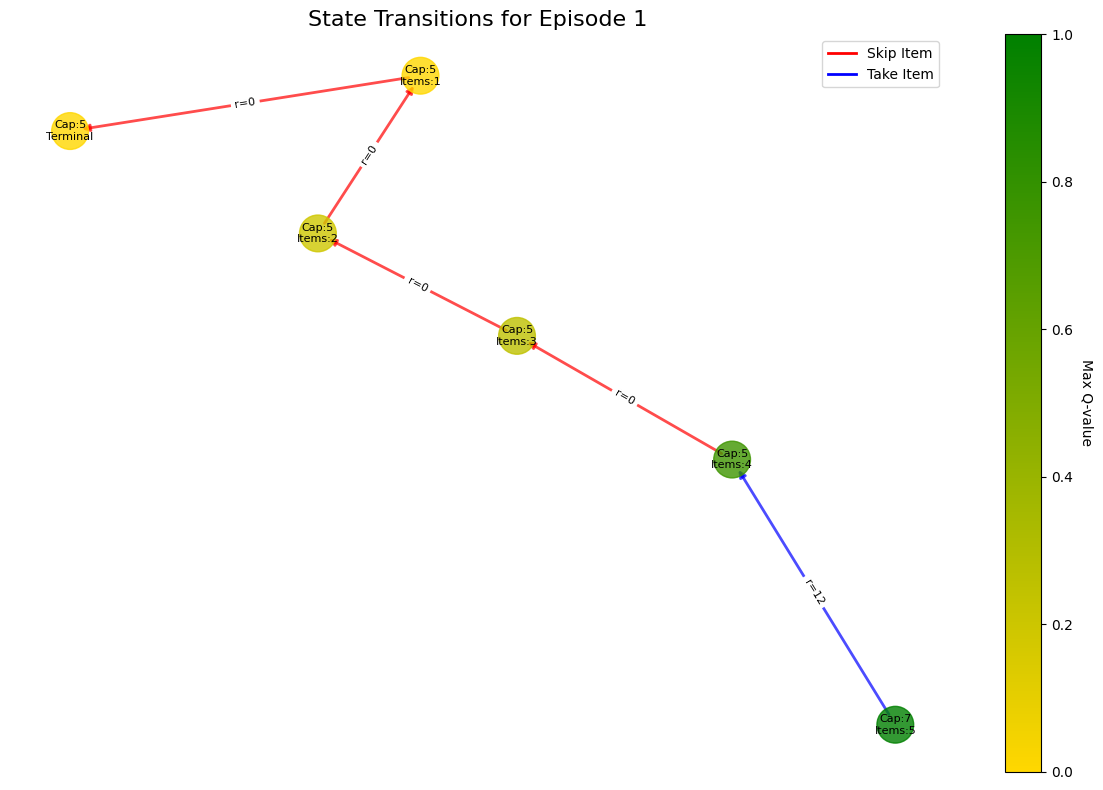


Generating visualization for Episode 10...
Saved visualization to episode_10_transitions.png


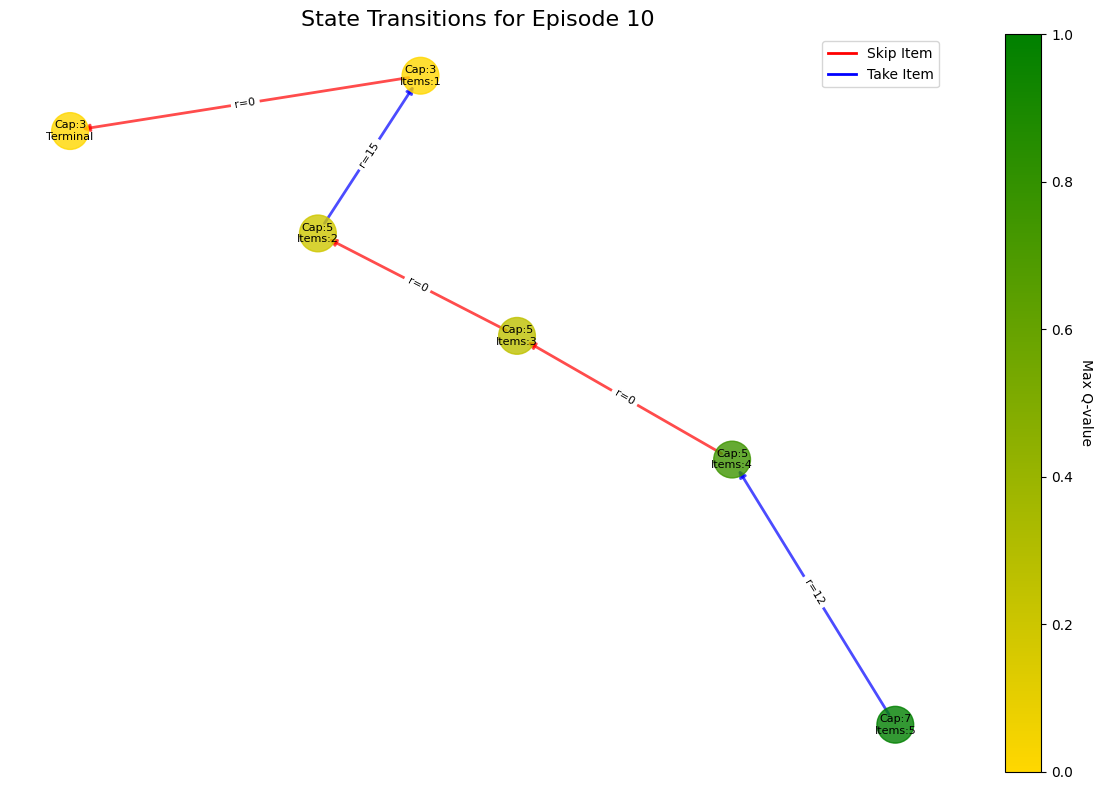


Generating visualization for Episode 25...
Saved visualization to episode_25_transitions.png


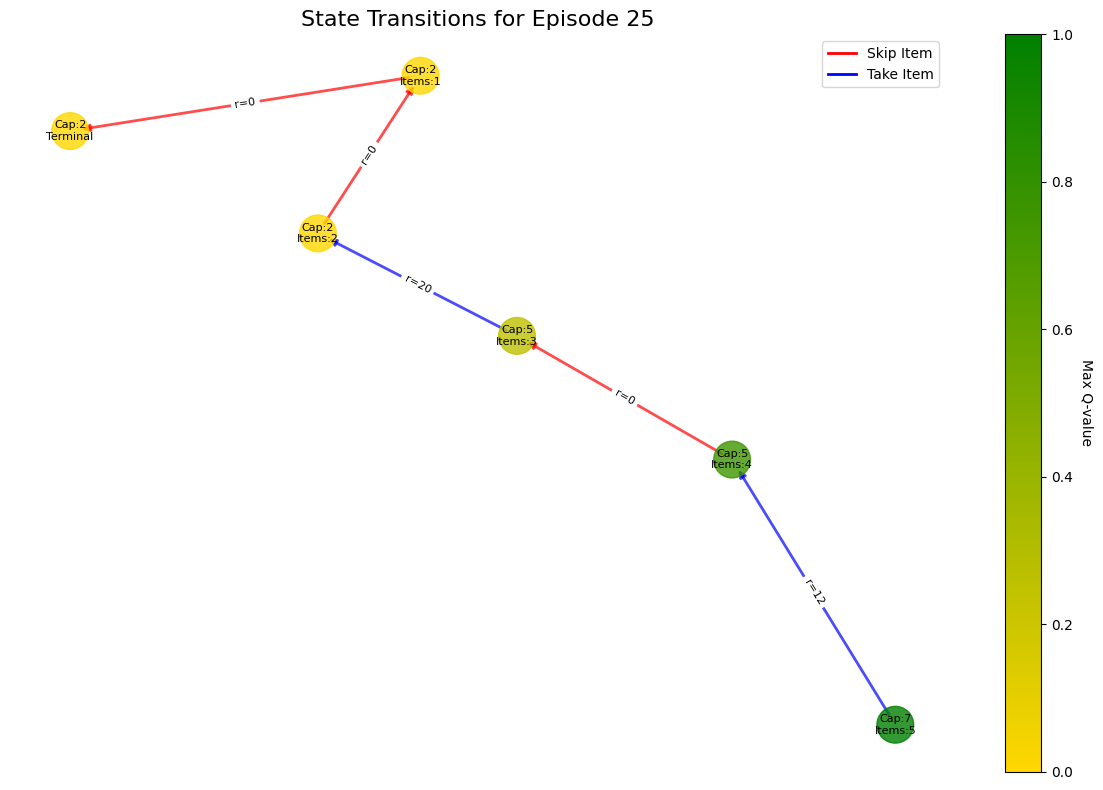


Generating visualization for Episode 50...
Saved visualization to episode_50_transitions.png


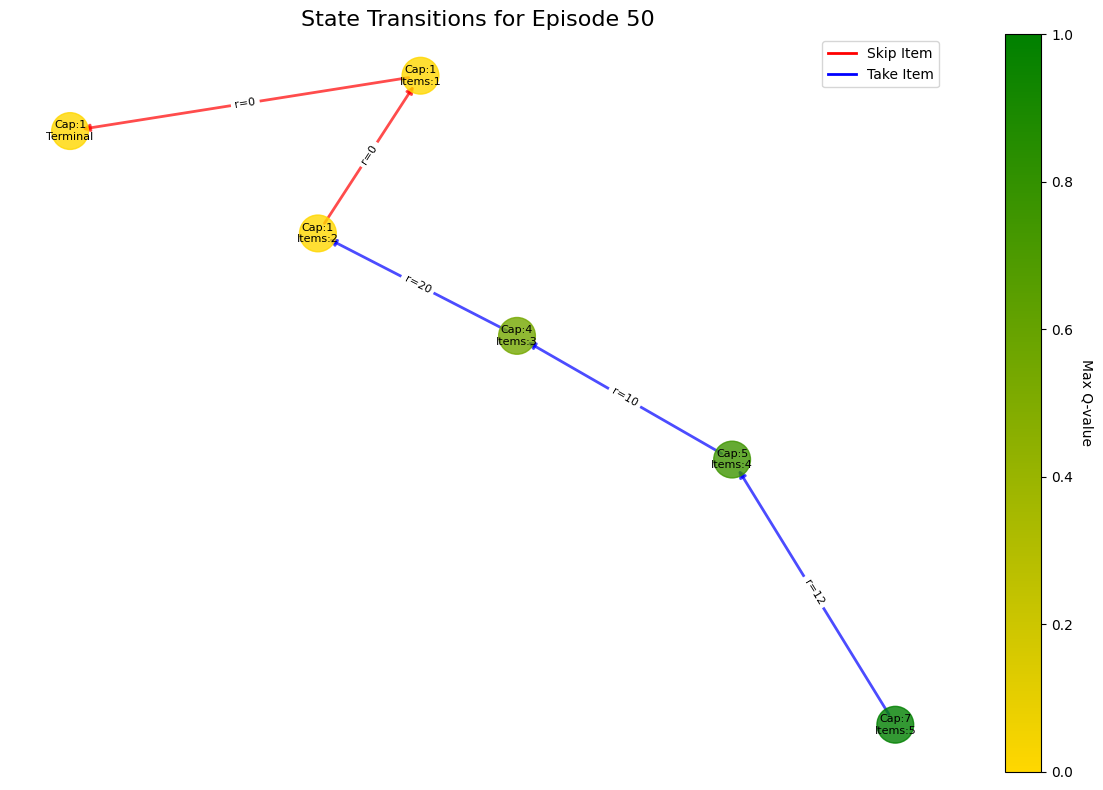


Generating visualization for Episode 100...
Saved visualization to episode_100_transitions.png


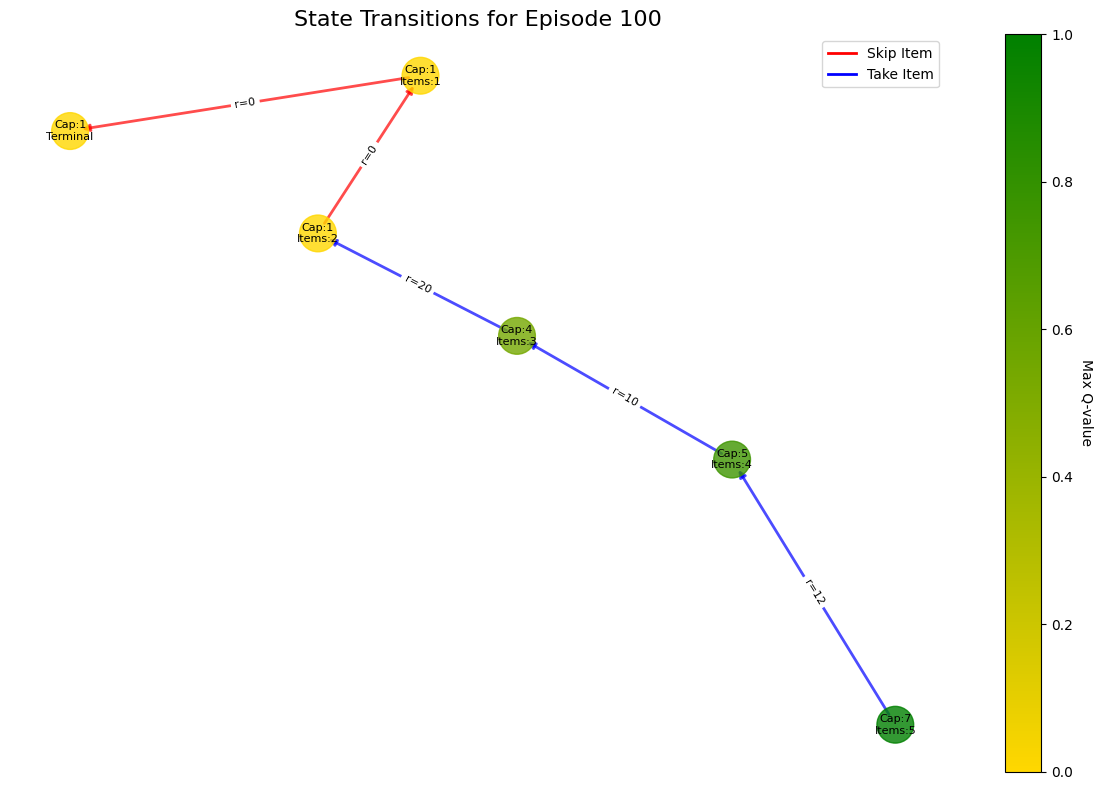


LEARNING EVOLUTION VISUALIZATION

Generating learning evolution visualization...
Saved visualization to transition_evolution.png


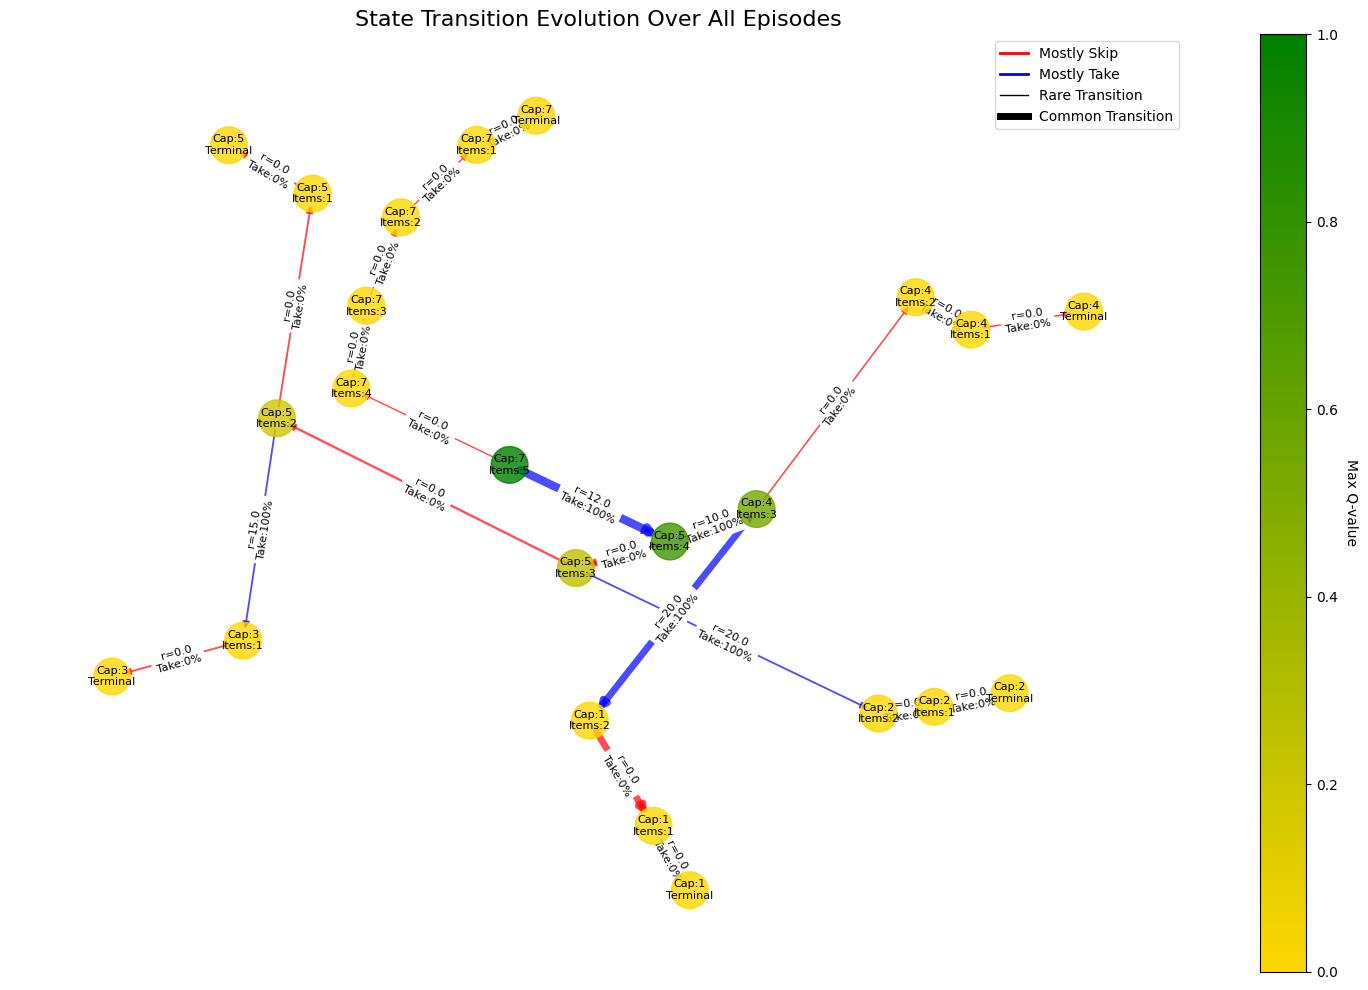


OPTIMAL POLICY PATH VISUALIZATION

Generating optimal policy path visualization...
Saved visualization to optimal_policy_path.png


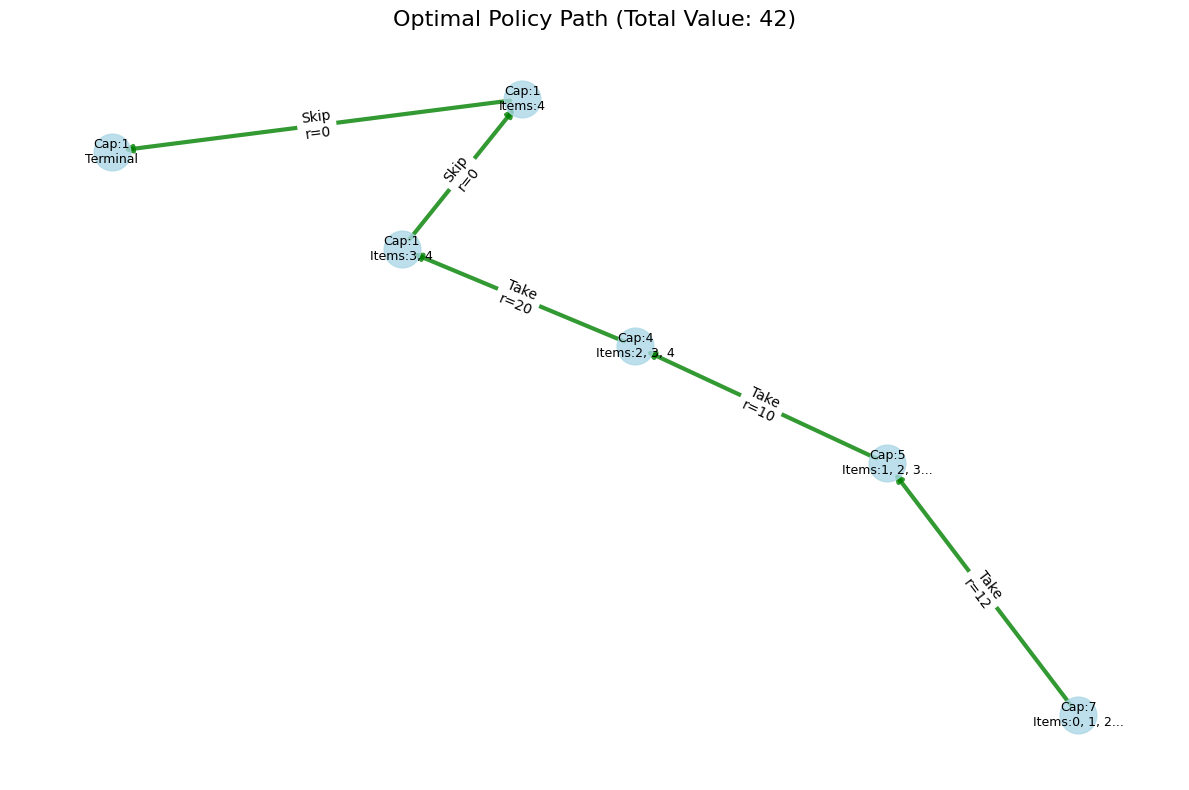

In [6]:

import random
import time
from tabulate import tabulate  # For pretty printing tables
from colorama import Fore, Back, Style, init  # For colored terminal output
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import numpy as np
# Initialize colorama
init(autoreset=True)

class KnapsackQLearning:
    def __init__(self, weights, values, capacity, 
                alpha=0.1, gamma=0.9, epsilon=0.1, max_episodes=200):
        """
        Initialize the Q-learning agent for the knapsack problem.
        
        Parameters:
        -----------
        weights : list
            Weights of the items
        values : list
            Values of the items
        capacity : int
            Capacity of the knapsack
        alpha : float
            Learning rate
        gamma : float
            Discount factor
        epsilon : float
            Exploration rate
        max_episodes : int
            Maximum number of episodes for training
        """
        self.weights = weights
        self.values = values
        self.capacity = capacity
        self.n_items = len(weights)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_episodes = max_episodes
        
        # Initialize Q-table as a dictionary (for sparse representation)
        self.q_table = {}
        
        # Initialize episode history
        self.episode_history = []
        
        # Add structures to track state transitions for visualization
        self.episode_transitions = {}  # Dictionary to store transitions for each episode
        self.transition_counts = {}    # Dictionary to track how often each transition occurs
        
        # Print problem setup
        self._print_problem_setup()
    
    def _print_problem_setup(self):
        """Print the problem setup with nice formatting."""
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}Q-LEARNING FOR KNAPSACK PROBLEM")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print(f"\n{Fore.YELLOW}Problem Setup:")
        print(f"  - Items: {self.n_items}")
        print(f"  - Weights: {self.weights}")
        print(f"  - Values: {self.values}")
        print(f"  - Knapsack Capacity: {self.capacity}")
        
        print(f"\n{Fore.YELLOW}Learning Parameters:")
        print(f"  - Learning Rate (α): {self.alpha}")
        print(f"  - Discount Factor (γ): {self.gamma}")
        print(f"  - Exploration Rate (ε): {self.epsilon}")
        print(f"  - Maximum Episodes: {self.max_episodes}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "-"*80)
    
    def _get_state_key(self, state):
        """Convert state to a hashable tuple for Q-table lookup."""
        return (state[0], tuple(state[1]))
    
    def choose_action(self, state):
        """
        Choose an action using epsilon-greedy policy.
        
        Parameters:
        -----------
        state : tuple
            Current state (remaining_capacity, remaining_items)
            
        Returns:
        --------
        int
            Action (0: skip, 1: take)
        """
        state_key = self._get_state_key(state)
        remaining_capacity, remaining_items = state
        
        # If no items left or first item doesn't fit, must skip
        if not remaining_items or self.weights[remaining_items[0]] > remaining_capacity:
            return 0
        
        # Initialize Q-values for this state if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {0: 0.0, 1: 0.0}  # Skip and Take
        
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            # Explore: random action
            return random.randint(0, 1)
        else:
            # Exploit: choose best action
            return max(self.q_table[state_key], key=self.q_table[state_key].get)
    
    def _print_state_info(self, state, action, reward, next_state):
        """Print detailed information about the current state and action."""
        remaining_capacity, remaining_items = state
        next_capacity, next_items = next_state
        
        action_str = "TAKE" if action == 1 else "SKIP"
        item_idx = remaining_items[0] if remaining_items else None
        
        # Current state
        print(f"\n{Fore.GREEN}Current State:")
        print(f"  - Remaining Capacity: {remaining_capacity}")
        print(f"  - Remaining Items: {remaining_items}")
        
        # Action and item
        if item_idx is not None:
            print(f"\n{Fore.BLUE}Action: {action_str} Item {item_idx}")
            print(f"  - Item Weight: {self.weights[item_idx]}")
            print(f"  - Item Value: {self.values[item_idx]}")
        else:
            print(f"\n{Fore.BLUE}Action: {action_str} (No items left)")
        
        # Reward
        print(f"\n{Fore.MAGENTA}Reward: {reward}")
        
        # Next state
        print(f"\n{Fore.GREEN}Next State:")
        print(f"  - Remaining Capacity: {next_capacity}")
        print(f"  - Remaining Items: {next_items}")
    
    def _print_q_update(self, state, action, old_q, reward, next_state, next_max_q, new_q):
        """Print the detailed Q-value update calculation."""
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        print(f"\n{Fore.YELLOW}Q-Value Update Calculation:")
        print(f"  - Current Q(s,a): Q{state_key, action} = {old_q:.4f}")
        
        if len(next_state[1]) > 0:  # If next state has items
            print(f"  - Next State Max Q-Value: max_a Q{next_state_key, 'a'} = {next_max_q:.4f}")
            print(f"  - TD Target: r + γ * max_a Q(s',a') = {reward} + {self.gamma} * {next_max_q:.4f} = {reward + self.gamma * next_max_q:.4f}")
        else:
            print(f"  - TD Target: r (terminal state) = {reward}")
        
        td_error = reward + self.gamma * next_max_q - old_q
        print(f"  - TD Error: r + γ * max_a Q(s',a') - Q(s,a) = {td_error:.4f}")
        
        print(f"  - Q-Update: Q(s,a) ← Q(s,a) + α * TD Error")
        print(f"    = {old_q:.4f} + {self.alpha} * {td_error:.4f}")
        print(f"    = {old_q:.4f} + {self.alpha * td_error:.4f}")
        print(f"    = {new_q:.4f}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}Updated Q-Value: Q{state_key, action} = {new_q:.4f}")
    
    def _print_q_table(self, highlight_state=None, highlight_action=None):
        """Print the current Q-table in a readable format."""
        if not self.q_table:
            print(f"\n{Fore.YELLOW}Q-Table is empty.")
            return
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}Current Q-Table:")
        
        # Prepare table data
        headers = ["State (Capacity, Items)", "Q(s,Skip)", "Q(s,Take)"]
        table_data = []
        
        # Sort states for consistent display
        sorted_states = sorted(self.q_table.keys())
        
        for state_key in sorted_states:
            skip_value = self.q_table[state_key].get(0, "N/A")
            take_value = self.q_table[state_key].get(1, "N/A")
            
            if skip_value != "N/A":
                skip_value = f"{skip_value:.4f}"
            if take_value != "N/A":
                take_value = f"{take_value:.4f}"
            
            # Highlight the updated state-action pair
            if highlight_state and highlight_state == state_key:
                if highlight_action == 0:
                    skip_value = f"{Fore.GREEN}{Style.BRIGHT}{skip_value}{Style.RESET_ALL}"
                elif highlight_action == 1:
                    take_value = f"{Fore.GREEN}{Style.BRIGHT}{take_value}{Style.RESET_ALL}"
            
            table_data.append([str(state_key), skip_value, take_value])
        
        # Print table
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    def update_q_value(self, state, action, reward, next_state, verbose=True):
        """
        Update the Q-value for the given state-action pair.
        
        Parameters:
        -----------
        state : tuple
            Current state (remaining_capacity, remaining_items)
        action : int
            Action taken (0: skip, 1: take)
        reward : float
            Reward received
        next_state : tuple
            Next state
        verbose : bool
            Whether to print detailed update information
        """
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        # Initialize Q-values if not seen before
        if state_key not in self.q_table:
            self.q_table[state_key] = {0: 0.0, 1: 0.0}
        if next_state_key not in self.q_table and len(next_state[1]) > 0:
            self.q_table[next_state_key] = {0: 0.0, 1: 0.0}
        
        # Get current Q-value
        old_q = self.q_table[state_key].get(action, 0.0)
        
        # Calculate next state's maximum Q-value
        if len(next_state[1]) > 0:  # If next state has items
            next_max_q = max(self.q_table[next_state_key].values())
        else:
            next_max_q = 0.0  # Terminal state
        
        # Q-learning update rule
        new_q = old_q + self.alpha * (reward + self.gamma * next_max_q - old_q)
        self.q_table[state_key][action] = new_q
        
        # Print detailed information if verbose
        if verbose:
            self._print_state_info(state, action, reward, next_state)
            self._print_q_update(state, action, old_q, reward, next_state, next_max_q, new_q)
            self._print_q_table(highlight_state=state_key, highlight_action=action)
        
        return new_q
    
    def run_episode(self, episode_num, verbose=True):
        """
        Run a single episode of Q-learning.
        
        Parameters:
        -----------
        episode_num : int
            Current episode number
        verbose : bool
            Whether to print detailed episode information
            
        Returns:
        --------
        total_reward : float
            Total reward collected in this episode
        """
        if verbose:
            print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
            print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE {episode_num}")
            print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        # Initialize state
        state = (self.capacity, tuple(range(self.n_items)))
        total_reward = 0
        selected_items = []
        
        # Initialize transition list for this episode
        self.episode_transitions[episode_num] = []
        
        while state[1]:  # While items remain
            state_key = self._get_state_key(state)
            
            # Choose action
            action = self.choose_action(state)
            
            # Get next item to consider
            item_idx = state[1][0]
            remaining_items = state[1][1:]
            
            # Take action and observe next state and reward
            if action == 1:  # Take item
                if self.weights[item_idx] <= state[0]:  # If can take
                    reward = self.values[item_idx]
                    next_state = (state[0] - self.weights[item_idx], remaining_items)
                    selected_items.append(item_idx)
                else:  # Cannot take, forced to skip
                    reward = 0
                    next_state = (state[0], remaining_items)
            else:  # Skip item
                reward = 0
                next_state = (state[0], remaining_items)
            
            next_state_key = self._get_state_key(next_state)
            
            # Record this transition for visualization
            transition = (state_key, action, reward, next_state_key)
            self.episode_transitions[episode_num].append(transition)
            
            # Update transition counts
            if (state_key, next_state_key) not in self.transition_counts:
                self.transition_counts[(state_key, next_state_key)] = 0
            self.transition_counts[(state_key, next_state_key)] += 1
            
            # Update Q-value
            if verbose:
                print(f"\n{Fore.YELLOW}Step with Item {item_idx}:")
            
            self.update_q_value(state, action, reward, next_state, verbose=verbose)
            
            # Update total reward and state
            total_reward += reward
            state = next_state
        
        if verbose:
            print(f"\n{Fore.GREEN}{Style.BRIGHT}Episode {episode_num} Complete")
            print(f"{Fore.GREEN}Total Reward: {total_reward}")
            print(f"{Fore.GREEN}Selected Items: {selected_items}")
        
        # Record episode history
        self.episode_history.append((episode_num, total_reward, selected_items))
        
        return total_reward
    
    def train(self, verbose_episodes=None):
        """
        Train the Q-learning agent over multiple episodes.
        
        Parameters:
        -----------
        verbose_episodes : list
            List of episode numbers to print detailed information for
            
        Returns:
        --------
        rewards : list
            List of rewards for each episode
        """
        if verbose_episodes is None:
            verbose_episodes = [1, 10, 50, 100]
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}STARTING TRAINING FOR {self.max_episodes} EPISODES")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        rewards = []
        
        for episode in range(1, self.max_episodes + 1):
            # Determine verbosity for this episode
            verbose = episode in verbose_episodes
            
            # Run episode
            reward = self.run_episode(episode, verbose=verbose)
            rewards.append(reward)
            
            # Print progress
            if episode % 10 == 0 and episode not in verbose_episodes:
                print(f"Episode {episode}/{self.max_episodes}, Reward: {reward}")
            
            # Decay exploration rate
            self.epsilon = max(0.01, self.epsilon * 0.99)
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}TRAINING COMPLETE")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        return rewards
    
    def get_optimal_policy(self):
        """
        Extract optimal policy from learned Q-values.
        
        Returns:
        --------
        policy : dict
            Mapping from states to actions
        value : float
            Expected total value from optimal policy
        selected_items : list
            List of items selected by optimal policy
        """
        policy = {}
        state = (self.capacity, tuple(range(self.n_items)))
        total_value = 0
        selected_items = []
        
        while state[1]:
            state_key = self._get_state_key(state)
            item_idx = state[1][0]
            remaining_items = state[1][1:]
            
            # Get action from Q-table
            if state_key in self.q_table:
                # If we can't take the item, we have to skip
                if self.weights[item_idx] > state[0]:
                    action = 0
                else:
                    action = max(self.q_table[state_key], key=self.q_table[state_key].get)
            else:
                # Default to skip if state not in Q-table
                action = 0
            
            policy[state_key] = action
            
            if action == 1 and self.weights[item_idx] <= state[0]:
                total_value += self.values[item_idx]
                selected_items.append(item_idx)
                state = (state[0] - self.weights[item_idx], remaining_items)
            else:
                state = (state[0], remaining_items)
        
        return policy, total_value, selected_items
    
    def print_optimal_policy(self):
        """Print the optimal policy and solution."""
        policy, value, items = self.get_optimal_policy()
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}OPTIMAL SOLUTION FOUND")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print(f"\n{Fore.GREEN}Optimal Value: {value}")
        print(f"{Fore.GREEN}Selected Items: {items}")
        
        # Calculate weight
        total_weight = sum(self.weights[i] for i in items)
        print(f"{Fore.GREEN}Total Weight: {total_weight}/{self.capacity}")
        
        print(f"\n{Fore.YELLOW}Item Details:")
        table_data = []
        for i in range(self.n_items):
            status = "Selected" if i in items else "Not Selected"
            status_color = Fore.GREEN if i in items else Fore.RED
            table_data.append([i, self.weights[i], self.values[i], f"{status_color}{status}{Style.RESET_ALL}"])
        
        headers = ["Item", "Weight", "Value", "Status"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        print(f"\n{Fore.YELLOW}Optimal Policy:")
        table_data = []
        for state, action in policy.items():
            action_str = "Take" if action == 1 else "Skip"
            table_data.append([str(state), action_str])
        
        headers = ["State", "Action"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    def visualize_training_progress(self):
        """Visualize the training progress (text-based)."""
        episodes = [ep for ep, _, _ in self.episode_history]
        rewards = [r for _, r, _ in self.episode_history]
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}TRAINING PROGRESS")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        # Calculate best episode and reward
        best_ep_idx = np.argmax(rewards)
        best_episode = episodes[best_ep_idx]
        best_reward = rewards[best_ep_idx]
        best_items = self.episode_history[best_ep_idx][2]
        
        print(f"\n{Fore.GREEN}Best Episode: {best_episode}")
        print(f"{Fore.GREEN}Best Reward: {best_reward}")
        print(f"{Fore.GREEN}Best Items: {best_items}")
        
        # Print reward progress
        print(f"\n{Fore.YELLOW}Reward Progress:")
        
        # Generate a simple text-based progress chart
        max_reward = max(rewards)
        chart_width = 50
        
        for i, (ep, reward) in enumerate(zip(episodes, rewards)):
            if i % 10 == 0 or i == len(episodes) - 1:
                bar_length = int(reward / max_reward * chart_width)
                bar = "#" * bar_length
                print(f"Episode {ep:3d}: {reward:3.0f} |{bar}")
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)

    def visualize_state_transitions(self, episode_nums=None):
        """
        Visualize state transitions as a directed graph for specific episodes.
        
        Parameters:
        -----------
        episode_nums : list
            List of episode numbers to visualize. If None, visualizes all transitions.
        """
        if episode_nums is None:
            # Default: visualize a few key episodes
            episode_nums = [1, 10, 25, self.max_episodes]
        
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}STATE TRANSITION VISUALIZATIONS")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        for episode_num in episode_nums:
            if episode_num not in self.episode_transitions:
                print(f"Episode {episode_num} not found in transitions data.")
                continue
            
            print(f"\nGenerating visualization for Episode {episode_num}...")
            
            # Create directed graph for this episode
            G = nx.DiGraph()
            
            # Get transitions for this episode
            transitions = self.episode_transitions[episode_num]
            
            # Add nodes and edges to the graph
            for state_key, action, reward, next_state_key in transitions:
                # Add nodes if they don't exist
                if state_key not in G:
                    G.add_node(state_key)
                if next_state_key not in G:
                    G.add_node(next_state_key)
                
                # Add edge with action and reward as attributes
                G.add_edge(state_key, next_state_key, action=action, reward=reward)
            
            # Create a figure
            plt.figure(figsize=(12, 8))
            plt.title(f"State Transitions for Episode {episode_num}", fontsize=16)
            
            # Get Q-values for node colors
            node_colors = []
            for node in G.nodes():
                if node in self.q_table:
                    # Use the max Q-value for this state
                    max_q = max(self.q_table[node].values())
                    node_colors.append(max_q)
                else:
                    node_colors.append(0)
            
            # Normalize colors
            if node_colors:
                min_q = min(node_colors)
                max_q = max(node_colors)
                if min_q != max_q:
                    node_colors = [(q - min_q) / (max_q - min_q) for q in node_colors]
                else:
                    node_colors = [0.5 for _ in node_colors]
                                
            # Create layout
            pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)
            
            # Custom colormap: yellow (low values) to green (high values)
            cmap = LinearSegmentedColormap.from_list("q_values", ["#FFD700", "#008000"])
            
            # Draw nodes with color based on Q-values
            nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, cmap=cmap, alpha=0.8)
            
            # Draw edges with colors based on action (red=skip, blue=take)
            for u, v, data in G.edges(data=True):
                if data['action'] == 0:  # Skip
                    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='red')
                else:  # Take
                    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='blue')
            
            # Prepare edge labels (rewards)
            edge_labels = {(u, v): f"r={data['reward']}" for u, v, data in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
            
            # Prepare simplified node labels
            node_labels = {}
            for node in G.nodes():
                capacity, items = node
                if items:
                    node_labels[node] = f"Cap:{capacity}\nItems:{len(items)}"
                else:
                    node_labels[node] = f"Cap:{capacity}\nTerminal"
            
            nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
            
            # Add legend
            legend_elements = [
                Line2D([0], [0], color='red', lw=2, label='Skip Item'),
                Line2D([0], [0], color='blue', lw=2, label='Take Item')
            ]
            plt.legend(handles=legend_elements)
            
            # Add colorbar for Q-values
            sm = plt.cm.ScalarMappable(cmap=cmap)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=plt.gca())
            cbar.set_label('Max Q-value', rotation=270, labelpad=15)
            
            plt.axis('off')
            plt.tight_layout()
            
            # Save the figure
            filename = f"episode_{episode_num}_transitions.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved visualization to {filename}")
            
            plt.show()

    def visualize_learning_evolution(self):
        """
        Visualize how the state-transition graph evolves across multiple episodes.
        Creates a single graph with edge thickness indicating transition frequency.
        """
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}LEARNING EVOLUTION VISUALIZATION")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print("\nGenerating learning evolution visualization...")
        
        # Create directed graph for all transitions
        G = nx.DiGraph()
        
        # Get all transitions
        for episode, transitions in self.episode_transitions.items():
            for state_key, action, reward, next_state_key in transitions:
                # Add nodes if they don't exist
                if state_key not in G:
                    G.add_node(state_key)
                if next_state_key not in G:
                    G.add_node(next_state_key)
                
                # Add or update edge
                if G.has_edge(state_key, next_state_key):
                    # Update existing edge
                    edge_data = G[state_key][next_state_key]
                    # Track actions and rewards
                    if 'actions' not in edge_data:
                        edge_data['actions'] = {0: 0, 1: 0}
                    edge_data['actions'][action] += 1
                    
                    # Update rewards (average)
                    if 'rewards' not in edge_data:
                        edge_data['rewards'] = []
                    edge_data['rewards'].append(reward)
                    
                    # Count transitions
                    if 'count' not in edge_data:
                        edge_data['count'] = 0
                    edge_data['count'] += 1
                else:
                    # Create new edge
                    G.add_edge(state_key, next_state_key, 
                               actions={0: 0, 1: 0}, 
                               rewards=[reward],
                               count=1)
                    G[state_key][next_state_key]['actions'][action] = 1
        
        # Create a figure
        plt.figure(figsize=(15, 10))
        plt.title(f"State Transition Evolution Over All Episodes", fontsize=16)
        
        # Get final Q-values for node colors
        node_colors = []
        for node in G.nodes():
            if node in self.q_table:
                # Use the max Q-value for this state
                max_q = max(self.q_table[node].values())
                node_colors.append(max_q)
            else:
                node_colors.append(0)
        
        # Normalize colors
        if node_colors:
            min_q = min(node_colors)
            max_q = max(node_colors)
            if min_q != max_q:
                node_colors = [(q - min_q) / (max_q - min_q) for q in node_colors]
            else:
                node_colors = [0.5 for _ in node_colors]
        
        # Create layout
        pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)
        
        # Custom colormap: yellow (low values) to green (high values)
        cmap = LinearSegmentedColormap.from_list("q_values", ["#FFD700", "#008000"])
        
        # Draw nodes with color based on Q-values
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, cmap=cmap, alpha=0.8)
        
        # Prepare edge widths and colors based on transition counts and dominant action
        edge_colors = []
        edge_widths = []
        max_count = max([data['count'] for _, _, data in G.edges(data=True)])
        
        for _, _, data in G.edges(data=True):
            # Scale width by transition count
            width = 1 + 5 * data['count'] / max_count
            edge_widths.append(width)
            
            # Color based on dominant action
            if data['actions'][1] > data['actions'][0]:
                edge_colors.append('blue')  # Take dominated
            else:
                edge_colors.append('red')   # Skip dominated
        
        # Draw edges
        edges = list(G.edges())
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, alpha=0.7)
        
        # Prepare edge labels (average rewards)
        edge_labels = {}
        for u, v, data in G.edges(data=True):
            avg_reward = sum(data['rewards']) / len(data['rewards'])
            take_pct = 100 * data['actions'][1] / data['count']
            edge_labels[(u, v)] = f"r={avg_reward:.1f}\nTake:{take_pct:.0f}%"
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        # Prepare simplified node labels
        node_labels = {}
        for node in G.nodes():
            capacity, items = node
            if items:
                node_labels[node] = f"Cap:{capacity}\nItems:{len(items)}"
            else:
                node_labels[node] = f"Cap:{capacity}\nTerminal"
        
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
        
        # Add legend
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, label='Mostly Skip'),
            Line2D([0], [0], color='blue', lw=2, label='Mostly Take'),
            Line2D([0], [0], color='black', lw=1, label='Rare Transition'),
            Line2D([0], [0], color='black', lw=5, label='Common Transition')
        ]
        plt.legend(handles=legend_elements)
        
        # Add colorbar for Q-values
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label('Max Q-value', rotation=270, labelpad=15)
        
        plt.axis('off')
        plt.tight_layout()
        
        # Save figure
        filename = "transition_evolution.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {filename}")
        
        plt.show()

    def visualize_optimal_path(self):
        """
        Visualize the optimal path through the state space after learning is complete.
        """
        print(f"\n{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        print(f"{Fore.CYAN}{Style.BRIGHT}OPTIMAL POLICY PATH VISUALIZATION")
        print(f"{Fore.CYAN}{Style.BRIGHT}" + "="*80)
        
        print("\nGenerating optimal policy path visualization...")
        
        # Get optimal policy
        policy, total_value, selected_items = self.get_optimal_policy()
        
        # Create directed graph
        G = nx.DiGraph()
        
        # Trace through the policy to find the optimal path
        state = (self.capacity, tuple(range(self.n_items)))
        path_edges = []
        
        while state[1]:  # While items remain
            state_key = self._get_state_key(state)
            item_idx = state[1][0]
            remaining_items = state[1][1:]
            
            # Get action from policy
            if state_key in policy:
                action = policy[state_key]
            else:
                action = 0  # Default to skip
            
            # Determine next state based on action
            if action == 1 and self.weights[item_idx] <= state[0]:  # Take
                reward = self.values[item_idx]
                next_state = (state[0] - self.weights[item_idx], remaining_items)
            else:  # Skip
                reward = 0
                next_state = (state[0], remaining_items)
            
            next_state_key = self._get_state_key(next_state)
            
            # Add nodes
            if state_key not in G:
                G.add_node(state_key)
            if next_state_key not in G:
                G.add_node(next_state_key)
            
            # Add edge
            G.add_edge(state_key, next_state_key, action=action, reward=reward)
            path_edges.append((state_key, next_state_key))
            
            # Move to next state
            state = next_state
        
        # Create layout
        pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Optimal Policy Path (Total Value: {total_value})", fontsize=16)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.8)
        
        # Draw optimal path edges with distinct color
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, edge_color='green', alpha=0.8)
        
        # Prepare edge labels (rewards and actions)
        edge_labels = {}
        for u, v, data in G.edges(data=True):
            action_str = "Take" if data['action'] == 1 else "Skip"
            edge_labels[(u, v)] = f"{action_str}\nr={data['reward']}"
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
        
        # Prepare node labels
        node_labels = {}
        for node in G.nodes():
            capacity, items = node
            if items:
                item_list = ", ".join(map(str, items[:3]))
                if len(items) > 3:
                    item_list += "..."
                node_labels[node] = f"Cap:{capacity}\nItems:{item_list}"
            else:
                node_labels[node] = f"Cap:{capacity}\nTerminal"
        
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)
        
        plt.axis('off')
        plt.tight_layout()
        
        # Save figure
        filename = "optimal_policy_path.png" 
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {filename}")
        
        plt.show()

def main():
    """Main function to run the Q-learning algorithm for the knapsack problem."""
    # Define problem
    weights = [2, 1, 3, 2, 4]
    values = [12, 10, 20, 15, 25]
    capacity = 7
    
    # Create agent
    agent = KnapsackQLearning(
        weights=weights,
        values=values,
        capacity=capacity,
        alpha=0.1,  # Learning rate
        gamma=0.9,  # Discount factor
        epsilon=0.1,  # Exploration rate
        max_episodes=100  # Maximum episodes
    )
    
    # Train the agent with verbose episodes
    verbose_episodes = [1, 10, 25, 50]
    rewards = agent.train(verbose_episodes=verbose_episodes)
    
    # Print the optimal policy
    agent.print_optimal_policy()
    
    # Visualize training progress
    agent.visualize_training_progress()
    
    # Visualize state transitions for specific episodes
    agent.visualize_state_transitions(episode_nums=[1, 10, 25, 50, 100])
    
    # Visualize learning evolution across all episodes
    agent.visualize_learning_evolution()
    
    # Visualize the optimal policy path
    agent.visualize_optimal_path()


if __name__ == "__main__":
    main()